In [4]:
import spacy
import re
from spacy import displacy
from spacy.matcher import Matcher
from spacy.tokens import Span
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

nlp = spacy.load('en_core_web_sm')

In [5]:
df = pd.read_csv('/content/wiki_sentences_v2.csv')
print(df.shape)
df.head()

(4318, 1)


,sentence
0,"confused and frustrated, connie decides to leave on her own."
1,"later, a woman’s scream is heard in the distance."
2,christian is then paralyzed by an elder.
3,the temple is set on fire.
4,"outside, the cult wails with him."


# Entities Extraction

The main idea is to go through a sentence and extract the subject and the object as and when they are encountered.

In [7]:
def get_entities(sent):
  ent1 = ''
  ent2 = ''

  prev_dep = ''
  prev_text = ''

  prefix = ''
  modifier = ''

  for tok in nlp(sent):
    if tok.dep_ != 'punct':
      if tok.dep_ == 'compound':
        prefix = tok.text
        if prev_dep == 'compound':
          prefix = prev_text + " "+ tok.text

      if tok.dep_.endswith('mod') == True:
        modifier = tok.text
        if prev_dep == 'compound':
          modifier = prev_text + " "+ tok.text

      if tok.dep_.find('subj') == True:
        ent1 = modifier + " " + prefix + " " + tok.text
        prefix = ""
        modifier = ""
        prev_dep = ""
        prev_text = ""

      if tok.dep_.find('obj') == True:
        ent2 = modifier + " " + prefix + " " +tok.text

      prev_dep = tok.dep_
      prev_text = tok.text
  return [ent1.strip(), ent2.strip()]

In [8]:
get_entities("the film had 200 patents")

['film', '200  patents']

In [9]:
entity_pairs = []

for i in tqdm(df['sentence']):
  entity_pairs.append(get_entities(i))

100%|██████████| 4318/4318 [00:30<00:00, 141.92it/s]


# Relation Extraction

In [10]:
def get_relation(sent):
  doc = nlp(sent)

  matcher = Matcher(nlp.vocab)
  pattern = [{'DEP':'ROOT'},
             {'DEP':'prep', 'OP':'?'},
             {'DEP':'agent', 'OP':'?'},
             {'POS':'ADJ', 'OP':'?'}]
  
  matcher.add('matching', None, pattern)

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]]

  return (span.text)

In [11]:
get_relation('John completed the task')

'completed'

In [12]:
relations = [get_relation(i) for i in tqdm(df['sentence'])]

100%|██████████| 4318/4318 [00:29<00:00, 148.29it/s]


# Build a Knowledge Graph

In [15]:
source = [i[0] for i in entity_pairs]

target = [i[1] for i in entity_pairs]

kg = pd.DataFrame({'source':source, 'target':target,'edge':relations})

In [16]:
kg.head()

,source,target,edge
0,connie,own,decides
1,later woman,distance,heard in
2,christian,then elder,paralyzed by
3,temple,fire,set on
4,outside cult,him,wails with


In [17]:
G = nx.from_pandas_edgelist(kg, 'source', 'target', edge_attr=True, create_using=nx.MultiDiGraph())

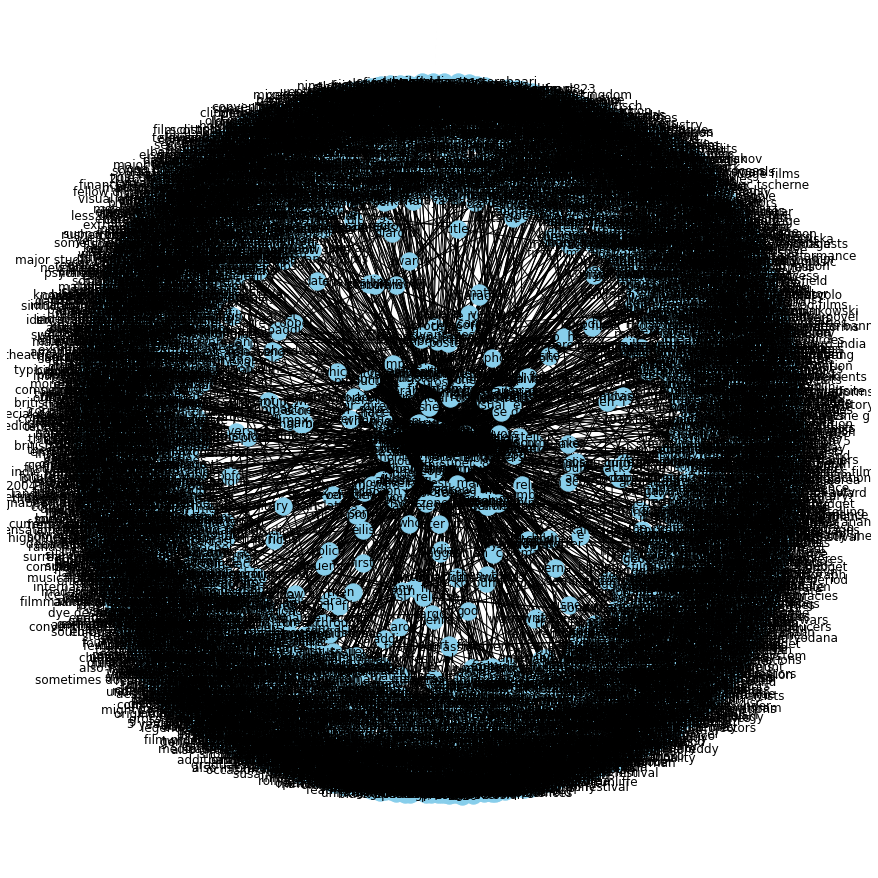

In [18]:
plt.figure(figsize=(12, 12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos=pos)
plt.show()

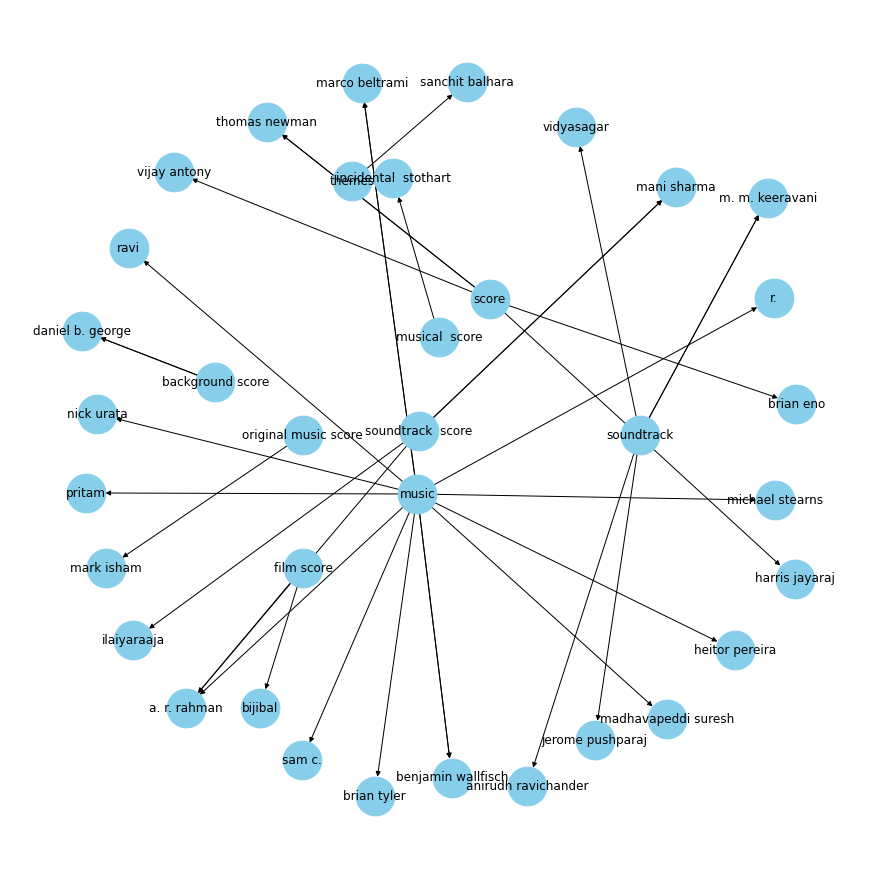

In [19]:
G = nx.from_pandas_edgelist(kg[kg['edge']=='composed by'], 'source','target', edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap = plt.cm.Blues, pos=pos)
plt.show()

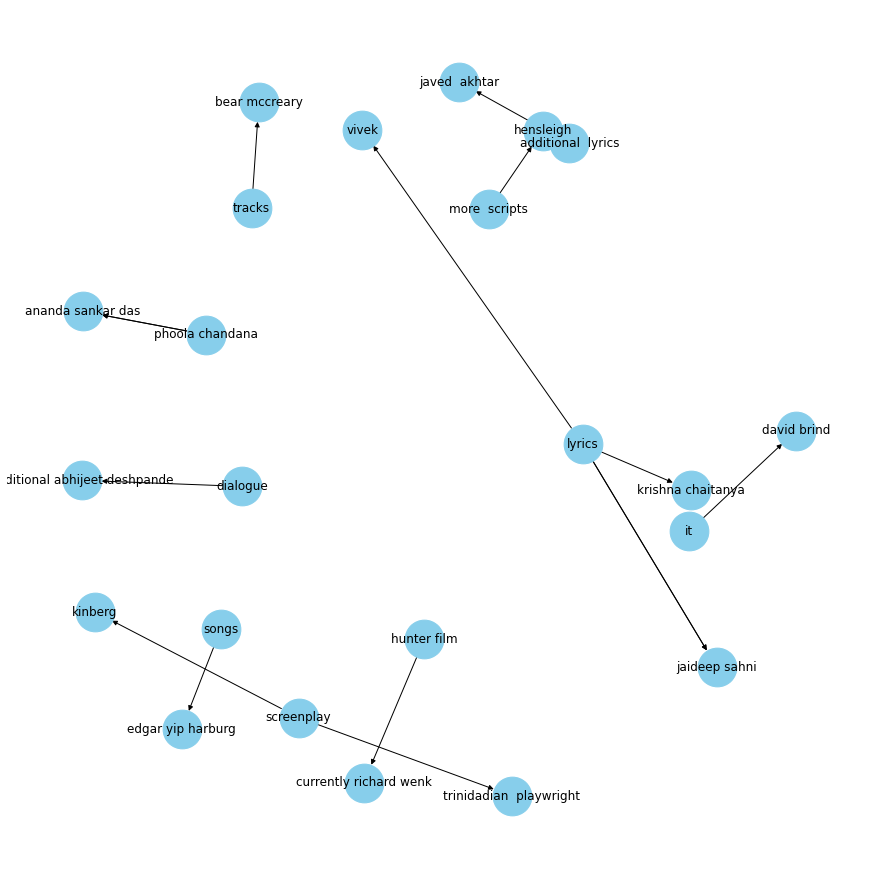

In [21]:
G = nx.from_pandas_edgelist(kg[kg['edge']=='written by'], 'source', 'target', edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos=pos)
plt.show()